# Exploratory Data Analysis (EDA) for Facebook Crawled Data

This notebook analyzes the posts collected from Facebook pages by the crawler.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
from pathlib import Path
from datetime import datetime

# Set plot style
sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

## 1. Load Data

Load the crawled Facebook data from `fb_data.json`.

In [2]:
def load_facebook_data(file_path="fb_data.json"):
    """Load Facebook data from JSON file."""
    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            data = json.load(f)
        print(f"Loaded {len(data)} posts from {file_path}")
        return pd.DataFrame(data)
    except FileNotFoundError:
        print(f"File {file_path} not found!")
        return pd.DataFrame()
    except Exception as e:
        print(f"Error loading data: {e}")
        return pd.DataFrame()

df = load_facebook_data()
if not df.empty:
    print(f"\nDataframe shape: {df.shape}")
    print(f"\nColumns: {df.columns.tolist()}")
    display(df.head())

Loaded 105 posts from fb_data.json

Dataframe shape: (105, 7)

Columns: ['page_name', 'published_time', 'crawl_time', 'time_label', 'content', 'media', 'stats']


,page_name,published_time,crawl_time,time_label,content,media,stats
0,Theanh28,2025-12-05T23:02:18.166453,2025-12-05T23:36:18.166437,34 phút,Mở bài cái kết bài luôn sau 2 ngày 😅\n\nCre: a...,{'images': ['Có thể là hình ảnh về điện thoại ...,"{'likes': 2300, 'comments': 105, 'shares': 19}"
1,Theanh28,2025-12-05T22:44:18.167248,2025-12-05T23:36:18.166437,52 phút,Giải thưởng Chính - VINFUTURE GRAND PRIZE 2025...,{'images': ['Có thể là hình ảnh về TV và văn b...,"{'likes': 228, 'comments': 6, 'shares': 2}"
2,Theanh28,2025-12-05T22:39:18.167654,2025-12-05T23:36:18.166437,57 phút,"Thương bố không biết để đâu cho hết...\n\n""Tha...",{'images': ['Có thể là hình ảnh về văn bản cho...,"{'likes': 9100, 'comments': 106, 'shares': 60}"
3,Theanh28,2025-12-05T22:36:18.168107,2025-12-05T23:36:18.166437,1 giờ,"""Mẹ chồng cưng con gái của mẹ hơn cưng trứng, ...",{'images': ['Có thể là hình ảnh về văn bản cho...,"{'likes': 4800, 'comments': 396, 'shares': 19}"
4,Theanh28,2025-12-05T21:36:18.168805,2025-12-05T23:36:18.166437,2 giờ,"Năm 2025, Quảng Ngãi có 4.071 cặp vợ chồng ly ...","{'images': ['Có thể là hình ảnh về văn bản'], ...","{'likes': 3000, 'comments': 230, 'shares': 45}"


## 2. Data Cleaning & Preprocessing

In [3]:
if not df.empty:
    # Convert published_time to datetime
    df['published_time'] = pd.to_datetime(df['published_time'], errors='coerce')
    df['crawl_time'] = pd.to_datetime(df['crawl_time'], errors='coerce')
    
    # Extract date components
    df['published_date'] = df['published_time'].dt.date
    df['published_hour'] = df['published_time'].dt.hour
    
    # Extract stats into separate columns
    # Support both old format (likes) and new format (reactions object)
    if 'stats' in df.columns:
        def extract_total_reactions(x):
            if not isinstance(x, dict):
                return 0
            # New format: reactions is a nested dict
            if 'reactions' in x and isinstance(x['reactions'], dict):
                return x['reactions'].get('total', 0)
            # Old format: likes is a direct value
            return x.get('likes', 0)
        
        def extract_reaction_type(x, reaction_type):
            if not isinstance(x, dict):
                return 0
            if 'reactions' in x and isinstance(x['reactions'], dict):
                return x['reactions'].get(reaction_type, 0)
            # Old format: all reactions counted as "like"
            if reaction_type == 'like':
                return x.get('likes', 0)
            return 0
        
        # Total reactions (backward compatible with old 'likes' field)
        df['total_reactions'] = df['stats'].apply(extract_total_reactions)
        
        # Individual reaction types (new feature)
        for reaction_type in ['like', 'love', 'haha', 'wow', 'sad', 'angry']:
            df[reaction_type] = df['stats'].apply(lambda x: extract_reaction_type(x, reaction_type))
        
        # Keep 'likes' as alias for backward compatibility
        df['likes'] = df['total_reactions']
        
        df['comments'] = df['stats'].apply(lambda x: x.get('comments', 0) if isinstance(x, dict) else 0)
        df['shares'] = df['stats'].apply(lambda x: x.get('shares', 0) if isinstance(x, dict) else 0)
    
    # Extract media counts
    if 'media' in df.columns:
        df['image_count'] = df['media'].apply(lambda x: len(x.get('images', [])) if isinstance(x, dict) else 0)
        df['video_count'] = df['media'].apply(lambda x: len(x.get('videos', [])) if isinstance(x, dict) else 0)
        df['has_media'] = (df['image_count'] > 0) | (df['video_count'] > 0)
    
    # Calculate content length
    df['content_length'] = df['content'].apply(lambda x: len(x) if isinstance(x, str) else 0)
    
    print(f"Posts after preprocessing: {len(df)}")
    display(df.info())

Posts after preprocessing: 105
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105 entries, 0 to 104
Data columns (total 23 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   page_name        105 non-null    object        
 1   published_time   105 non-null    datetime64[ns]
 2   crawl_time       105 non-null    datetime64[ns]
 3   time_label       105 non-null    object        
 4   content          105 non-null    object        
 5   media            105 non-null    object        
 6   stats            105 non-null    object        
 7   published_date   105 non-null    object        
 8   published_hour   105 non-null    int32         
 9   total_reactions  105 non-null    int64         
 10  like             105 non-null    int64         
 11  love             105 non-null    int64         
 12  haha             105 non-null    int64         
 13  wow              105 non-null    int64         
 14  sad        

None

## 3. Basic Statistics

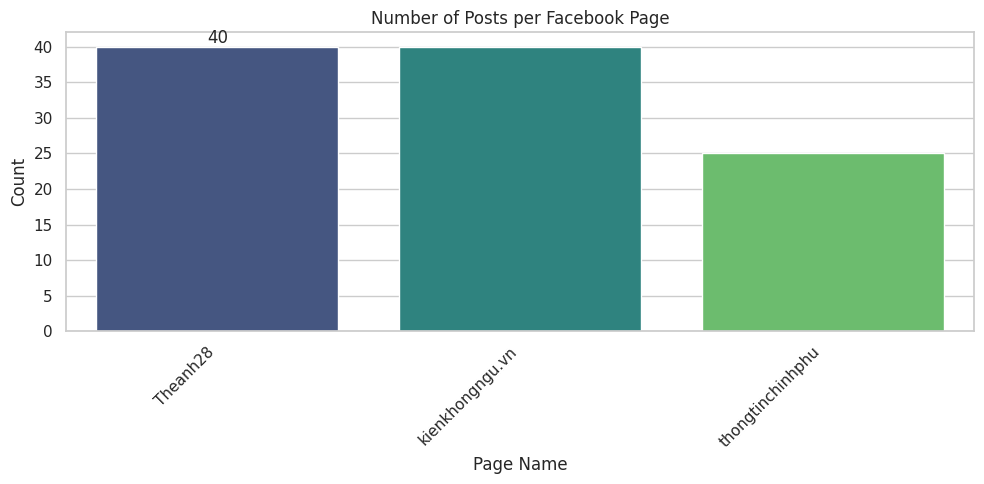

In [4]:
if not df.empty:
    # Posts per Page
    plt.figure(figsize=(10, 5))
    page_counts = df['page_name'].value_counts()
    ax = sns.barplot(x=page_counts.index, y=page_counts.values, hue=page_counts.index, palette="viridis", legend=False)
    ax.bar_label(ax.containers[0])
    plt.title("Number of Posts per Facebook Page")
    plt.xlabel("Page Name")
    plt.ylabel("Count")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

## 4. Engagement Analysis

,likes,comments,shares
count,105.000000,105.000000,105.000000
mean,6243.942857,181.704762,123.533333
std,10008.642141,328.353788,182.507063
min,0.000000,0.000000,0.000000
25%,1400.000000,2.000000,10.000000
50%,3500.000000,49.000000,53.000000
75%,6900.000000,218.000000,152.000000
max,83000.000000,2000.000000,1000.000000


/tmp/ipykernel_174509/1306157879.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='page_name', y=col, ax=axes[idx], palette='Set2')
/tmp/ipykernel_174509/1306157879.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[idx].set_xticklabels(axes[idx].get_xticklabels(), rotation=45, ha='right')
/tmp/ipykernel_174509/1306157879.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='page_name', y=col, ax=axes[idx], palette='Set2')
/tmp/ipykernel_174509/1306157879.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a 

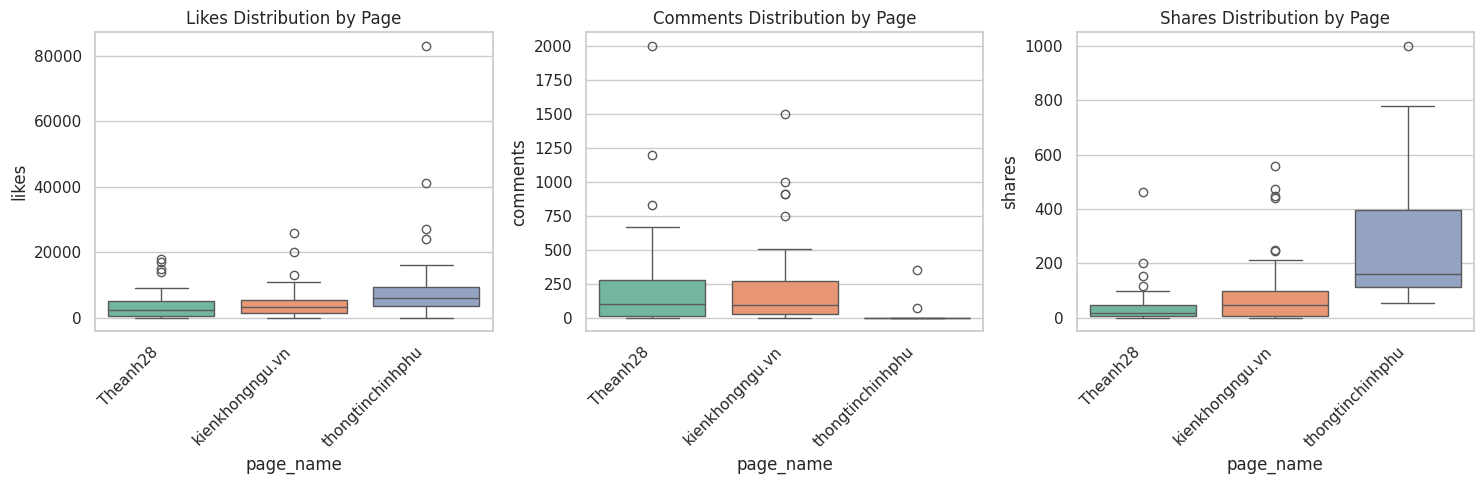

In [5]:
if not df.empty and 'likes' in df.columns:
    # Engagement statistics
    engagement_stats = df[['likes', 'comments', 'shares']].describe()
    display(engagement_stats)
    
    # Box plots for engagement metrics
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    for idx, col in enumerate(['likes', 'comments', 'shares']):
        sns.boxplot(data=df, x='page_name', y=col, ax=axes[idx], palette='Set2')
        axes[idx].set_title(f'{col.capitalize()} Distribution by Page')
        axes[idx].set_xticklabels(axes[idx].get_xticklabels(), rotation=45, ha='right')
    
    plt.tight_layout()
    plt.show()

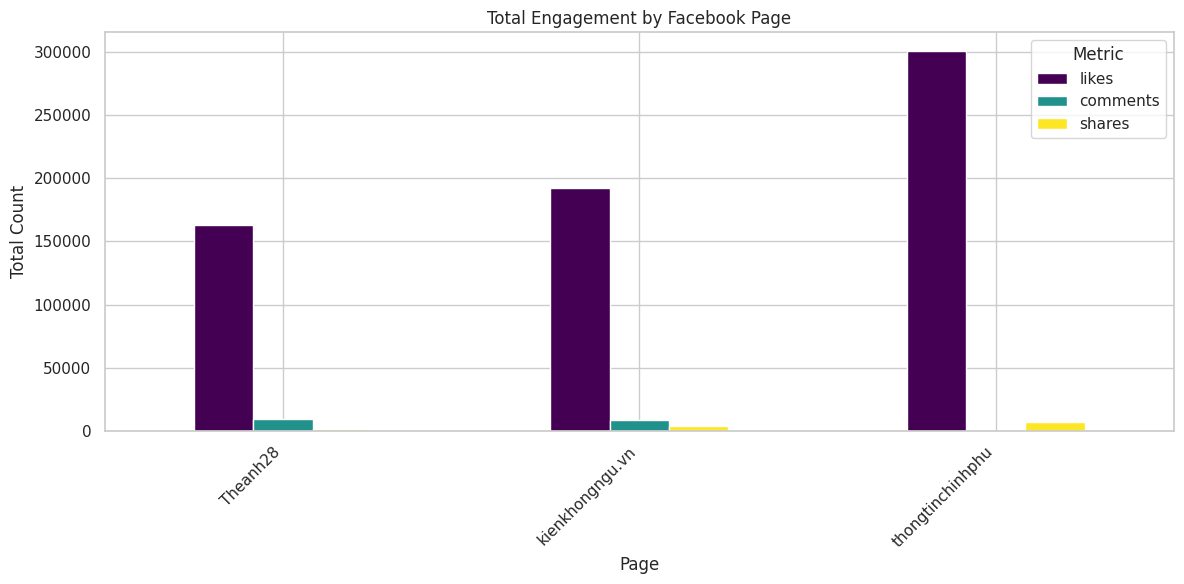

In [6]:
if not df.empty and 'likes' in df.columns:
    # Total engagement per page
    engagement_by_page = df.groupby('page_name')[['likes', 'comments', 'shares']].sum()
    
    fig, ax = plt.subplots(figsize=(12, 6))
    engagement_by_page.plot(kind='bar', ax=ax, colormap='viridis')
    plt.title('Total Engagement by Facebook Page')
    plt.xlabel('Page')
    plt.ylabel('Total Count')
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='Metric')
    plt.tight_layout()
    plt.show()

## 5. Content Analysis

/tmp/ipykernel_174509/2508965120.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='page_name', y='content_length', ax=axes[1], palette='Set3')
/tmp/ipykernel_174509/2508965120.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha='right')


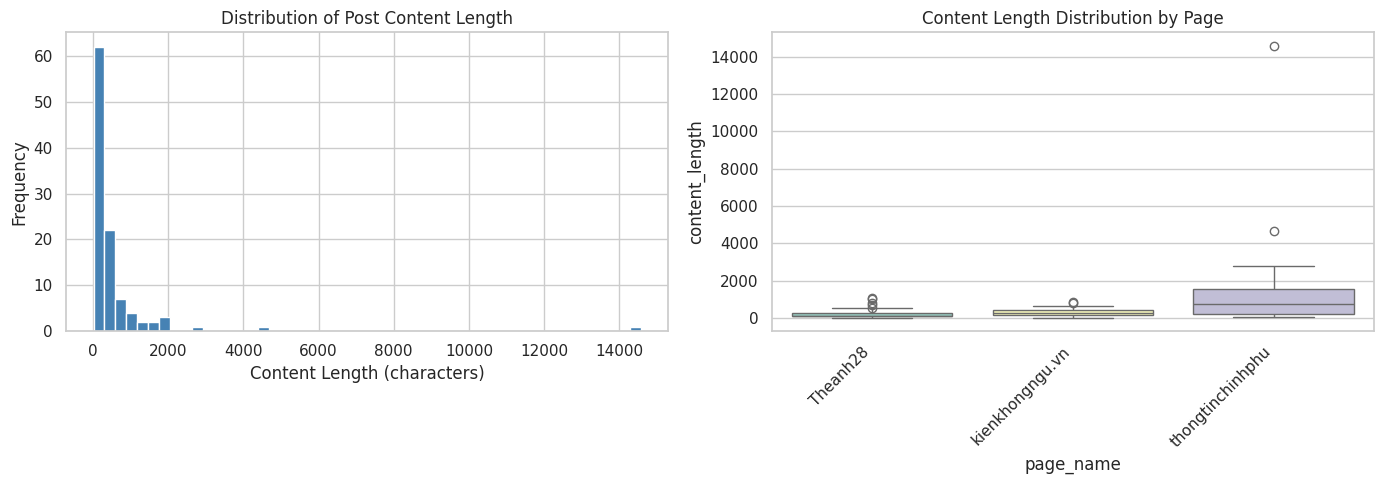

In [7]:
if not df.empty:
    # Content length distribution
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Histogram
    axes[0].hist(df['content_length'], bins=50, color='steelblue', edgecolor='white')
    axes[0].set_title('Distribution of Post Content Length')
    axes[0].set_xlabel('Content Length (characters)')
    axes[0].set_ylabel('Frequency')
    
    # Box plot by page
    sns.boxplot(data=df, x='page_name', y='content_length', ax=axes[1], palette='Set3')
    axes[1].set_title('Content Length Distribution by Page')
    axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha='right')
    
    plt.tight_layout()
    plt.show()

In [8]:
if not df.empty:
    # Average content length statistics
    content_stats = df.groupby('page_name')['content_length'].agg(['mean', 'median', 'min', 'max']).round(2)
    display(content_stats)

,mean,median,min,max
page_name,,,,
Theanh28,232.10,114.0,10,1044
kienkhongngu.vn,295.98,261.5,13,833
thongtinchinhphu,1567.04,742.0,56,14583


## 6. Media Analysis

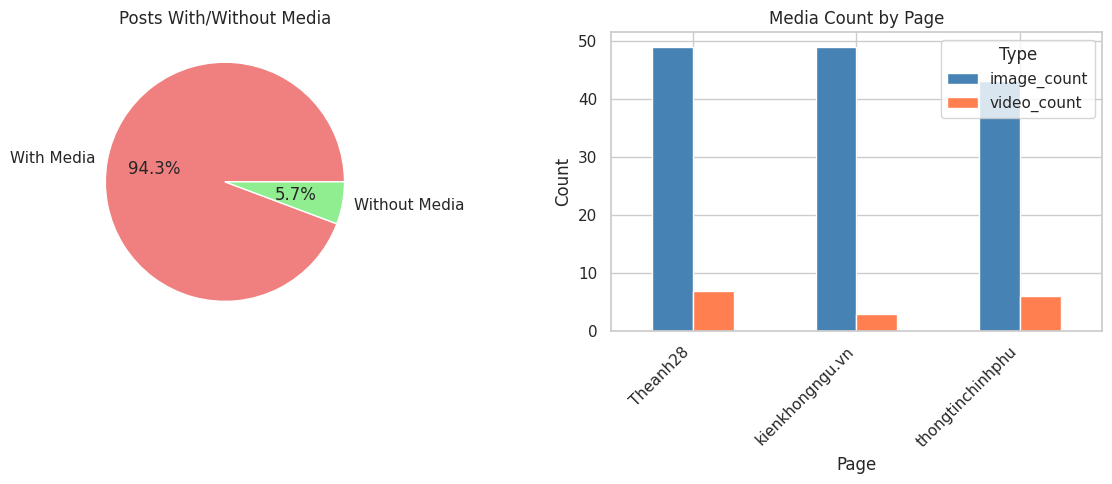

In [9]:
if not df.empty and 'has_media' in df.columns:
    # Media distribution
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    # Pie chart: Posts with/without media
    media_counts = df['has_media'].value_counts()
    labels = ['Without Media', 'With Media'] if not media_counts.index[0] else ['With Media', 'Without Media']
    axes[0].pie(media_counts.values, labels=labels, autopct='%1.1f%%', colors=['lightcoral', 'lightgreen'])
    axes[0].set_title('Posts With/Without Media')
    
    # Bar chart: Media types by page
    media_by_page = df.groupby('page_name')[['image_count', 'video_count']].sum()
    media_by_page.plot(kind='bar', ax=axes[1], color=['steelblue', 'coral'])
    axes[1].set_title('Media Count by Page')
    axes[1].set_xlabel('Page')
    axes[1].set_ylabel('Count')
    axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha='right')
    axes[1].legend(title='Type')
    
    plt.tight_layout()
    plt.show()

## 7. Temporal Analysis

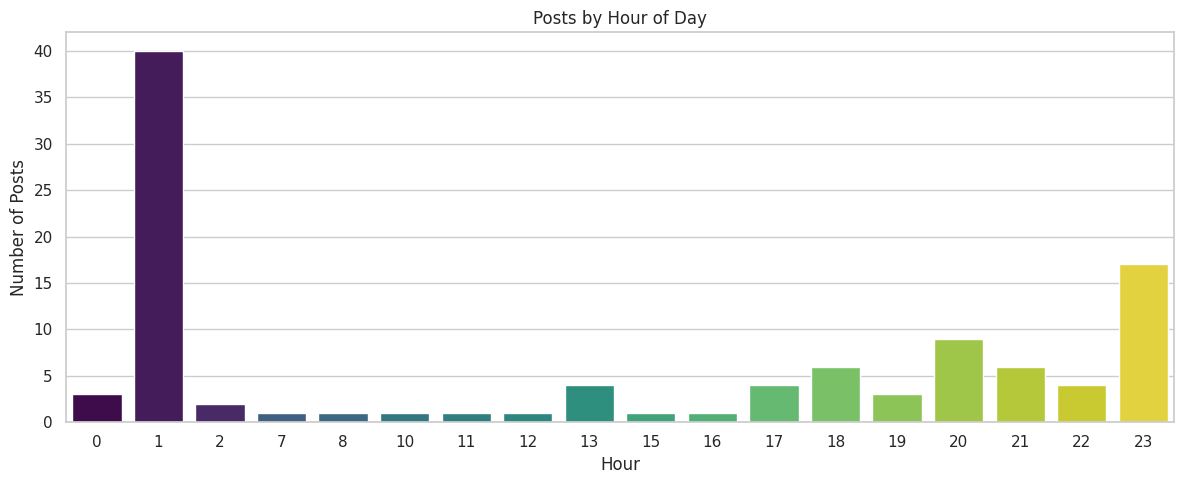

In [10]:
if not df.empty and 'published_hour' in df.columns:
    # Posts by hour of day
    fig, ax = plt.subplots(figsize=(12, 5))
    
    hour_counts = df['published_hour'].value_counts().sort_index()
    sns.barplot(x=hour_counts.index, y=hour_counts.values, ax=ax, hue=hour_counts.index, palette='viridis', legend=False)
    ax.set_title('Posts by Hour of Day')
    ax.set_xlabel('Hour')
    ax.set_ylabel('Number of Posts')
    
    plt.tight_layout()
    plt.show()

## 8. Engagement vs Content Length Correlation

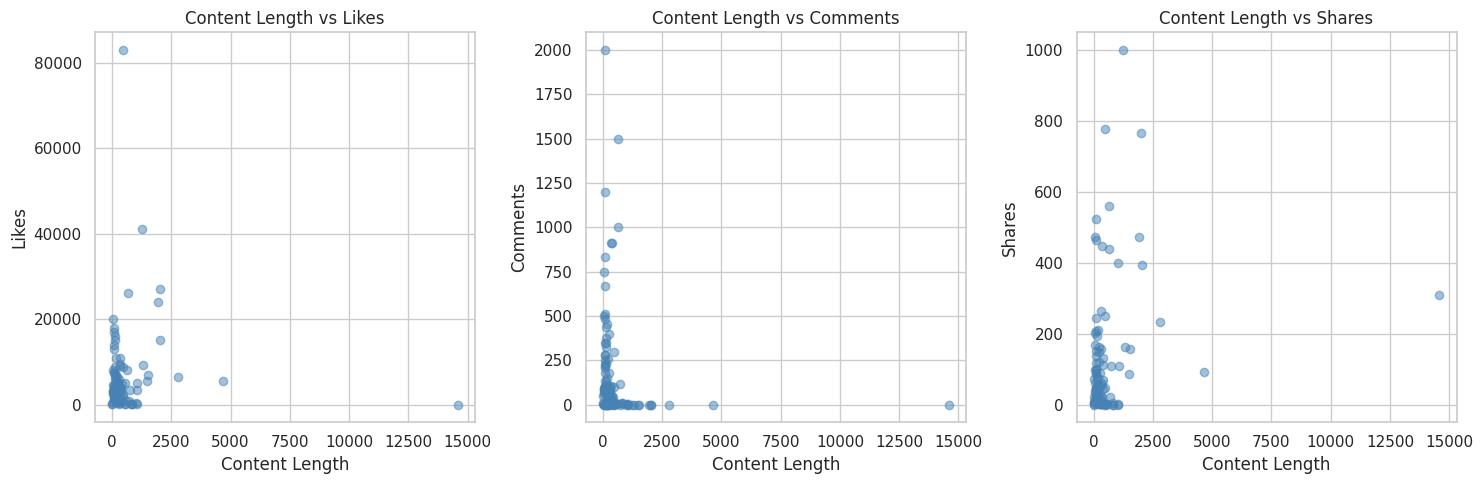

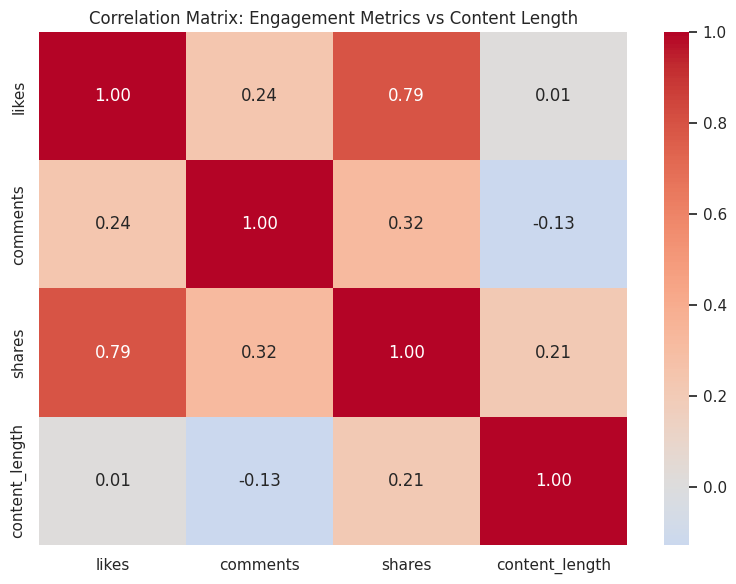

In [11]:
if not df.empty and all(col in df.columns for col in ['likes', 'content_length']):
    # Scatter plot: Content length vs engagement
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    for idx, metric in enumerate(['likes', 'comments', 'shares']):
        if metric in df.columns:
            axes[idx].scatter(df['content_length'], df[metric], alpha=0.5, c='steelblue')
            axes[idx].set_xlabel('Content Length')
            axes[idx].set_ylabel(metric.capitalize())
            axes[idx].set_title(f'Content Length vs {metric.capitalize()}')
    
    plt.tight_layout()
    plt.show()
    
    # Correlation matrix
    if all(col in df.columns for col in ['likes', 'comments', 'shares', 'content_length']):
        corr_cols = ['likes', 'comments', 'shares', 'content_length']
        corr_matrix = df[corr_cols].corr()
        
        plt.figure(figsize=(8, 6))
        sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
        plt.title('Correlation Matrix: Engagement Metrics vs Content Length')
        plt.tight_layout()
        plt.show()

## 9. Top Performing Posts

In [12]:
if not df.empty and 'likes' in df.columns:
    # Calculate total engagement
    df['total_engagement'] = df['likes'] + df['comments'] + df['shares']
    
    # Top 10 posts by engagement
    top_posts = df.nlargest(10, 'total_engagement')[['page_name', 'content', 'likes', 'comments', 'shares', 'total_engagement', 'published_time']]
    top_posts['content'] = top_posts['content'].apply(lambda x: x[:100] + '...' if len(x) > 100 else x)
    
    print("Top 10 Posts by Total Engagement:")
    display(top_posts)

Top 10 Posts by Total Engagement:


,page_name,content,likes,comments,shares,total_engagement,published_time
54,thongtinchinhphu,"👮 🇻🇳🤝🇰🇷 Đã bắt và vừa bàn giao Choi Jinwoo, Ch...",83000,0,778,83778,2025-12-05 02:37:41.763951
51,thongtinchinhphu,️🎯🚨 XỬ LÝ XE TẢI BỊ GỌI LÀ “CHIM MỒI” ĐI VÀO L...,41000,0,1000,42000,2025-12-05 08:37:41.763228
24,kienkhongngu.vn,Hôm nay tôi thấy có vụ này... \n\n1 người mẹ c...,26000,1500,439,27939,2025-12-05 18:36:54.687241
56,thongtinchinhphu,"‼️🆘 Bị các đối tượng lừa đảo liên tục đe dọa, ...",27000,0,767,27767,2025-12-05 01:37:41.764452
42,thongtinchinhphu,"🔴 TRUY NÃ LÊ TRUNG KHOA về tội “Làm, tàng trữ,...",24000,0,472,24472,2025-12-05 20:37:41.761049
91,kienkhongngu.vn,Một hình ảnh minh hoạ cho răng khôn =)))))\n󰍸\...,20000,746,474,21220,2025-12-08 00:56:35.765530
72,Theanh28,"‼ BÁO ĐỘNG: Tối nay, Hà Nội ô nhiễm\nnhất thế ...",17000,2000,463,19463,2025-12-08 01:07:01.006988
14,Theanh28,Khi 9X và 2X hẹn hò với nhau 😅\n\nCre: diaryof...,18000,831,202,19033,2025-12-05 18:36:18.172837
47,thongtinchinhphu,"🌊 📣 TRẮNG ĐÊM\n\nĐêm qua (4/12), tại phường Ph...",16000,348,522,16870,2025-12-05 13:37:41.762242
19,Theanh28,Tiết canh vịt của Việt Nam lọt top 50 món vịt ...,15000,1200,152,16352,2025-12-05 17:36:18.175326


## 10. Summary Statistics

In [13]:
if not df.empty:
    print("="*60)
    print("FACEBOOK CRAWL DATA SUMMARY")
    print("="*60)
    print(f"Total posts crawled: {len(df)}")
    print(f"Number of pages: {df['page_name'].nunique()}")
    print(f"Pages: {', '.join(df['page_name'].unique())}")
    print()
    
    if 'likes' in df.columns:
        print(f"Total likes: {df['likes'].sum():,}")
        print(f"Total comments: {df['comments'].sum():,}")
        print(f"Total shares: {df['shares'].sum():,}")
        print(f"Average engagement per post: {df['total_engagement'].mean():.2f}")
        print()
    
    if 'has_media' in df.columns:
        print(f"Posts with media: {df['has_media'].sum()} ({df['has_media'].mean()*100:.1f}%)")
        print(f"Total images: {df['image_count'].sum()}")
        print(f"Total videos: {df['video_count'].sum()}")
        print()
    
    print(f"Average content length: {df['content_length'].mean():.0f} characters")
    print("="*60)

FACEBOOK CRAWL DATA SUMMARY
Total posts crawled: 105
Number of pages: 3
Pages: Theanh28, kienkhongngu.vn, thongtinchinhphu

Total likes: 655,614
Total comments: 19,079
Total shares: 12,971
Average engagement per post: 6549.18

Posts with media: 99 (94.3%)
Total images: 141
Total videos: 16

Average content length: 574 characters
